In [8]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode

from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [9]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [10]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)


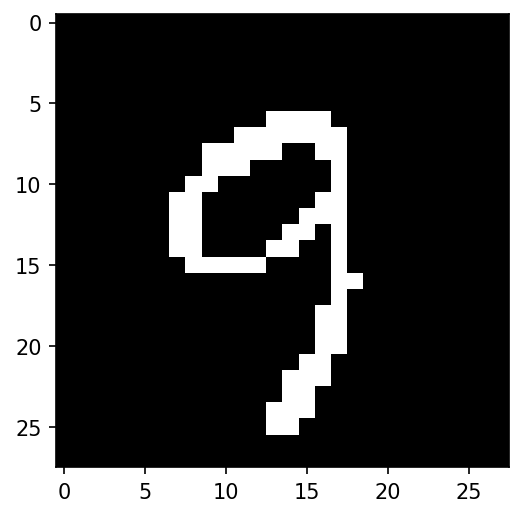

In [11]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

img = x_train[np.random.randint(0, x_train.shape[0])]
print(img.shape)

plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img, cmap="gray")

In [12]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [13]:
# Training setup
model = MNISTClassifier(image_depth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Training loop

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images.squeeze(0)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} loss: {total_loss}")

# Save the model
torch.save(model.state_dict(), "trained_models/mnist_model.pt")

Epoch 0 loss: 337.11738175642677
Epoch 1 loss: 108.04730561762699
Epoch 2 loss: 74.74374283735233
Epoch 3 loss: 55.79751666899938
Epoch 4 loss: 41.82574777460104
Epoch 5 loss: 32.32181996972304
Epoch 6 loss: 24.306635316474967
Epoch 7 loss: 19.132312305794812
Epoch 8 loss: 18.107533627872698
Epoch 9 loss: 13.799042423398873


In [14]:
model.eval()

with torch.no_grad():
    correct_preds = 0
    test_loss = 0
    for x, y in test_loader:
        pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()

        pred = pred.argmax(dim=1, keepdim=True)
        truth = y.argmax(dim=1, keepdim=True)
        correct_preds += pred.eq(truth.view_as(pred)).sum().item()
        

    test_accuracy = correct_preds / len(test_loader.dataset)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {100*test_accuracy}%")


Test loss: 12.931485379228818
Test accuracy: 98.9%
